## Next, we can calculate environmental burdens of sectors or entire energy system scenarios using the exported data packages exported in `1_export_packages.ipynb`.
Part of documentation and code is re-used from pathways: https://github.com/polca/pathways, credits to Romain Sacchi and Alvaro Hahn.

We start by instantiating the `Pathways` class, and give it a file path pointing to a datapackage.json of a datapackage or directly the datapackage itself (.zip file).

In [1]:
from pathways import Pathways, __file__
import numpy as np
import bw2data as bd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#select the ZIP file where transformation and LCA data are stored;
name_zip_file = r"remind-transience.zip"
name_zip_file = r"remind-transience_example_all.zip"

p = Pathways(
    datapackage=name_zip_file, #better to use ZIP file.
    debug=True # when `debug` is True, a local pathways.log file is created and allows tracking the workflow
)

Log file: C:\Users\terlouw_t\AppData\Local\pylca\pathways\Logs\pathways.log


At this point, you can access all the resources of the `datapackage.Package`, such as the scenario data, for example.
We see that the demand for `technology A`, represented by `product A` (see `.mapping`), is 1'000 kilograms (see `.scenarios.attrs`) each year.

For example, we could check how final energy evolves for transport over the years for the different scenarios in Europe:

In [2]:
df_scens = p.scenarios.to_dataframe("").reset_index()
df_scens[ (df_scens['variables'] == 'FE_transportation_electricity') &  (df_scens['year'] <= 2050) &  (df_scens['region'] == 'RER')]

,model,pathway,variables,region,year,
10268,remind,SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce,FE_transportation_electricity,RER,2025,0.22
10269,remind,SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce,FE_transportation_electricity,RER,2030,0.34
10270,remind,SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce,FE_transportation_electricity,RER,2040,1.46
10271,remind,SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce,FE_transportation_electricity,RER,2050,2.18
29116,remind,SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 Net...,FE_transportation_electricity,RER,2025,0.84
29117,remind,SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 Net...,FE_transportation_electricity,RER,2030,1.59
29118,remind,SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 Net...,FE_transportation_electricity,RER,2040,2.63
29119,remind,SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 Net...,FE_transportation_electricity,RER,2050,2.81


We can also see the mapping used in `p.mapping` to map the scenario variables to the LCA datasets.

We can also list the LCIA methods available. Choose climate change as main impact category for now:

In [3]:
met = [mt for mt in p.lcia_methods if 'EF v3.1 EN' in str(mt) and 'climate change' in mt][0]
met

'EF v3.1 EN15804 - climate change - global warming potential (GWP100)'

### We also have a bunch of impact categories related to (critical) material extraction:

In [4]:
[m for m in p.lcia_methods if "metals extraction" in m]

['RELICS - metals extraction - Aluminium',
 'RELICS - metals extraction - Antimony',
 'RELICS - metals extraction - Arsenic',
 'RELICS - metals extraction - Barium',
 'RELICS - metals extraction - Beryllium',
 'RELICS - metals extraction - Boron',
 'RELICS - metals extraction - Cadmium',
 'RELICS - metals extraction - Cerium',
 'RELICS - metals extraction - Chromium',
 'RELICS - metals extraction - Cobalt',
 'RELICS - metals extraction - Copper',
 'RELICS - metals extraction - Dolomite',
 'RELICS - metals extraction - Dysprosium',
 'RELICS - metals extraction - Erbium',
 'RELICS - metals extraction - Europium',
 'RELICS - metals extraction - Gadolinium',
 'RELICS - metals extraction - Gallium',
 'RELICS - metals extraction - Germanium',
 'RELICS - metals extraction - Gold',
 'RELICS - metals extraction - Graphite',
 'RELICS - metals extraction - Hafnium',
 'RELICS - metals extraction - Holmium',
 'RELICS - metals extraction - Indium',
 'RELICS - metals extraction - Iridium',
 'RELICS -

In [5]:
[m for m in p.lcia_methods if "EF v3.1 EN" in m]

['EF v3.1 EN15804 - acidification - accumulated exceedance (AE)',
 'EF v3.1 EN15804 - climate change - global warming potential (GWP100)',
 'EF v3.1 EN15804 - climate change: biogenic - global warming potential (GWP100)',
 'EF v3.1 EN15804 - climate change: fossil - global warming potential (GWP100)',
 'EF v3.1 EN15804 - climate change: GHG (EPD PCR) - global warming potential (GWP100)',
 'EF v3.1 EN15804 - climate change: land use and land use change - global warming potential (GWP100)',
 'EF v3.1 EN15804 - ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)',
 'EF v3.1 EN15804 - energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels',
 'EF v3.1 EN15804 - eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)',
 'EF v3.1 EN15804 - eutrophication: marine - fraction of nutrients reaching marine end compartment (N)',
 'EF v3.1 EN15804 - eutrophication: terrestrial - accumulated exceedance (AE)',
 'EF v3.1 E

And most importantly, once the `datapackage.Package` is loaded, we can use the method `Pathways.calculate()` to calculate the LCA impacts.

Arguments:

* `methods`: list[str]. LCIA methods to use. To get a complete list of available LCIA methods, call `.lcia_methods`
* `scenarios`: list[str]. List of scenarios you want to calculate the impacts for.
* `variables`: list[str]. List of variables you want to calculate the impacts for (if the demand for them is non-null)
* `regions`: list[str]. Regions for which you want to calculate the impacts, provided the specified variables have a non-null demand in these regions.
* `years`: list[int]. Years for which you want to calculate the impacts.
* `multiprocessing`: bool. Multiprocessing may accelerate the process, as it processes each year in parallel.
* `demand_cutoff`: float. Between 0 and 1. Defines a ratio below which demand values are ignored. The default is 0.001.
* `double_accounting`:list[list[str]]. List of predefined category paths to be adjusted to prevent double counting of activities. Each path indicates the hierarchical categories involved.
* `use_distributions`: bool. Number of iterations to use for Monte Carlo analyses. The default is 0 (i.e., regular analysis).

In the example below, we do so using a stochastic approach (i.e., `use_distributions=500`), leveraging on the uncertainty distributions we defined for each exchange in the datapackage. `bw2calc` and the underlying library `stats_array` generates 500 pseudo-random exchange values and update the technosphere and biosphere matrices between each iteration.

In [6]:
# add some units not defined by pathways itself:
p.units['Mt Crude steel'] = {'kilogram': '1e+9'}
p.units['Mt/year'] = {'kilogram': '1e+9'}
p.units

{'PJ/year': {'kilowatt hour': 277800000.0, 'megajoule': '1e+9'},
 'Mtonne/yr': {'kilogram': '1e+9'},
 'Mt/yr': {'kilogram': '1e+9'},
 'million ha': {'square meter': '1e+12'},
 'EJ/yr': {'kilowatt hour': 277800000000.0, 'megajoule': '1e+12'},
 'PJ/yr': {'kilowatt hour': 277800000.0, 'megajoule': '1e+9'},
 'PJ/yr.': {'kilowatt hour': 277800000.0, 'megajoule': '1e+9'},
 'TWh': {'kilowatt hour': '1e+9', 'megajoule': 3600000000.0},
 'bn tkm/yr': {'ton kilometer': '1e+9'},
 'bn pkm/yr': {'passenger kilometer': '1e+9'},
 'Mt CO2/yr': {'kilogram': '1e+9'},
 'Mt': {'kilogram': '1e+9'},
 'Mt Crude steel': {'kilogram': '1e+9'},
 'Mt/year': {'kilogram': '1e+9'}}

In [7]:
[v for v in p.scenarios.coords["variables"].values if v.startswith("steel_")]

['steel_primary',
 'steel_primary_ccs',
 'steel_primary_dri_h2',
 'steel_primary_dri_ng',
 'steel_primary_mo_electrolysis',
 'steel_secondary']

In [8]:
[v for v in p.scenarios.coords["variables"].values if v.startswith("FE_")]

['FE_cdr_beccs',
 'FE_cdr_daccs',
 'FE_co2_capture_fossil',
 'FE_co2_capture_fossil_ind',
 'FE_industry_process_electricity',
 'FE_industry_process_natural_gas',
 'FE_industry_process_heat',
 'FE_industry_process_hydrogen',
 'FE_industry_process_light_fuel_oil',
 'FE_industry_process_coal',
 'FE_non_energy_gas',
 'FE_non_energy_liquids',
 'FE_residential_electricity',
 'FE_residential_space_heating_gas',
 'FE_residential_space_heating_heat_pump_gas',
 'FE_residential_space_heating_hydrogen',
 'FE_residential_space_heating_light_fuel_oil',
 'FE_residential_space_heating_wood',
 'FE_residential_space_heating_solar',
 'FE_transportation_electricity',
 'FE_transportation_gas',
 'FE_transportation_hydrogen',
 'FE_transportation_liquids']

In [9]:
p_steel = p

### Now, we can, for example, calculate the results for different scenarios, years, and impact categories for final energy demand of OPEN-PROM:

In [10]:
methods_sel=['EF v3.1 EN15804 - climate change - global warming potential (GWP100)',
             'EF v3.1 EN15804 - human toxicity: carcinogenic - comparative toxic unit for human (CTUh)',
            #'EF v3.1 EN15804 - particulate matter formation - impact on human health',
             #'EF v3.1 EN15804 - acidification - accumulated exceedance (AE)',
            #'EF v3.1 EN15804 - ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)',
            #'EF v3.1 EN15804 - eutrophication: terrestrial - accumulated exceedance (AE)',
            #'EF v3.1 EN15804 - material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)',
            #'EF v3.1 EN15804 - ozone depletion - ozone depletion potential (ODP)',
           # 'RELICS - metals extraction - Silicon',
            'RELICS - metals extraction - Lithium',
             #'RELICS - metals extraction - Cobalt',
            'RELICS - metals extraction - Iridium',
             #'RELICS - metals extraction - Dysprosium',
            ]

In [11]:
p.calculate(
    methods=methods_sel,
    regions=["RER"],
    scenarios= p.scenarios.pathway.values.tolist(),
    variables= [v for v in p.scenarios.coords["variables"].values if v.startswith("FE_")],
    years=p.scenarios.coords["year"].values.tolist(),
    #years=[2050],
    #use_distributions=0,
    #demand_cutoff=0.001,
    multiprocessing=False,
    double_accounting = [["Industry", "Electricity"], ["Industry", "Heat"]],
)

Calculating LCA results for remind...
--- Calculating LCA results for SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce...
------ Calculating LCA results for 2025...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:45


------ Calculating LCA results for 2030...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:46


------ Calculating LCA results for 2040...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:38


------ Calculating LCA results for 2050...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:46


--- Calculating LCA results for SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZero_ce - fc_nz...
------ Calculating LCA results for 2025...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:50


------ Calculating LCA results for 2030...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:48


------ Calculating LCA results for 2040...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:48


------ Calculating LCA results for 2050...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:50


We can now access the attribute `.lca_results`, which is an `xarray.DataArray` where the results are stored. While we could directly format it into an `pandas.DataFrame`, it may cause RAM to overflow (because the array is sometimes very large). Instead, we can use `.export_results()`, saving the results as a pandas' DataFrame without zero values.

In [12]:
fp = p.export_results()
# interpolate in-between years
df = pd.read_parquet(fp, engine='pyarrow')
df = df[df["value"]!=0.0]
df = df[~df["value"].isnull()]
df=df.reset_index()
df[['year', 'scenario', 'impact_category','value']].groupby(['year', 'impact_category', 'scenario', ]).sum()/1e9

Results exported to results_20250519_101732.gzip


value
year impact_category                                    scenario                                                        
2025 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     3.984660e+03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  3.267632e+03
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     7.519385e-06
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  7.409368e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.915304e-10
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  6.352802e-08
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     4.689477e-03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.783523e-02
2030 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     3.594302e+03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  2.298340e+03
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     7.165292e-06
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.210230e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.597122e-10
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.384251e-07
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     6.849011e-03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  3.171107e-02
2040 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.623629e+03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.136014e+03
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     6.665759e-06
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.568607e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     8.671888e-11
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  2.465606e-06
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.863577e-02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.157583e-02
2050 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.366836e+03
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  4.636986e+02
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     7.309326e-06
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  6.552077e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     5.175964e-09
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.132810e-05
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     3.832223e-02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.081583e-02

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_28180\383938060.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_colors)  # or 'tab20b', 'tab20c'


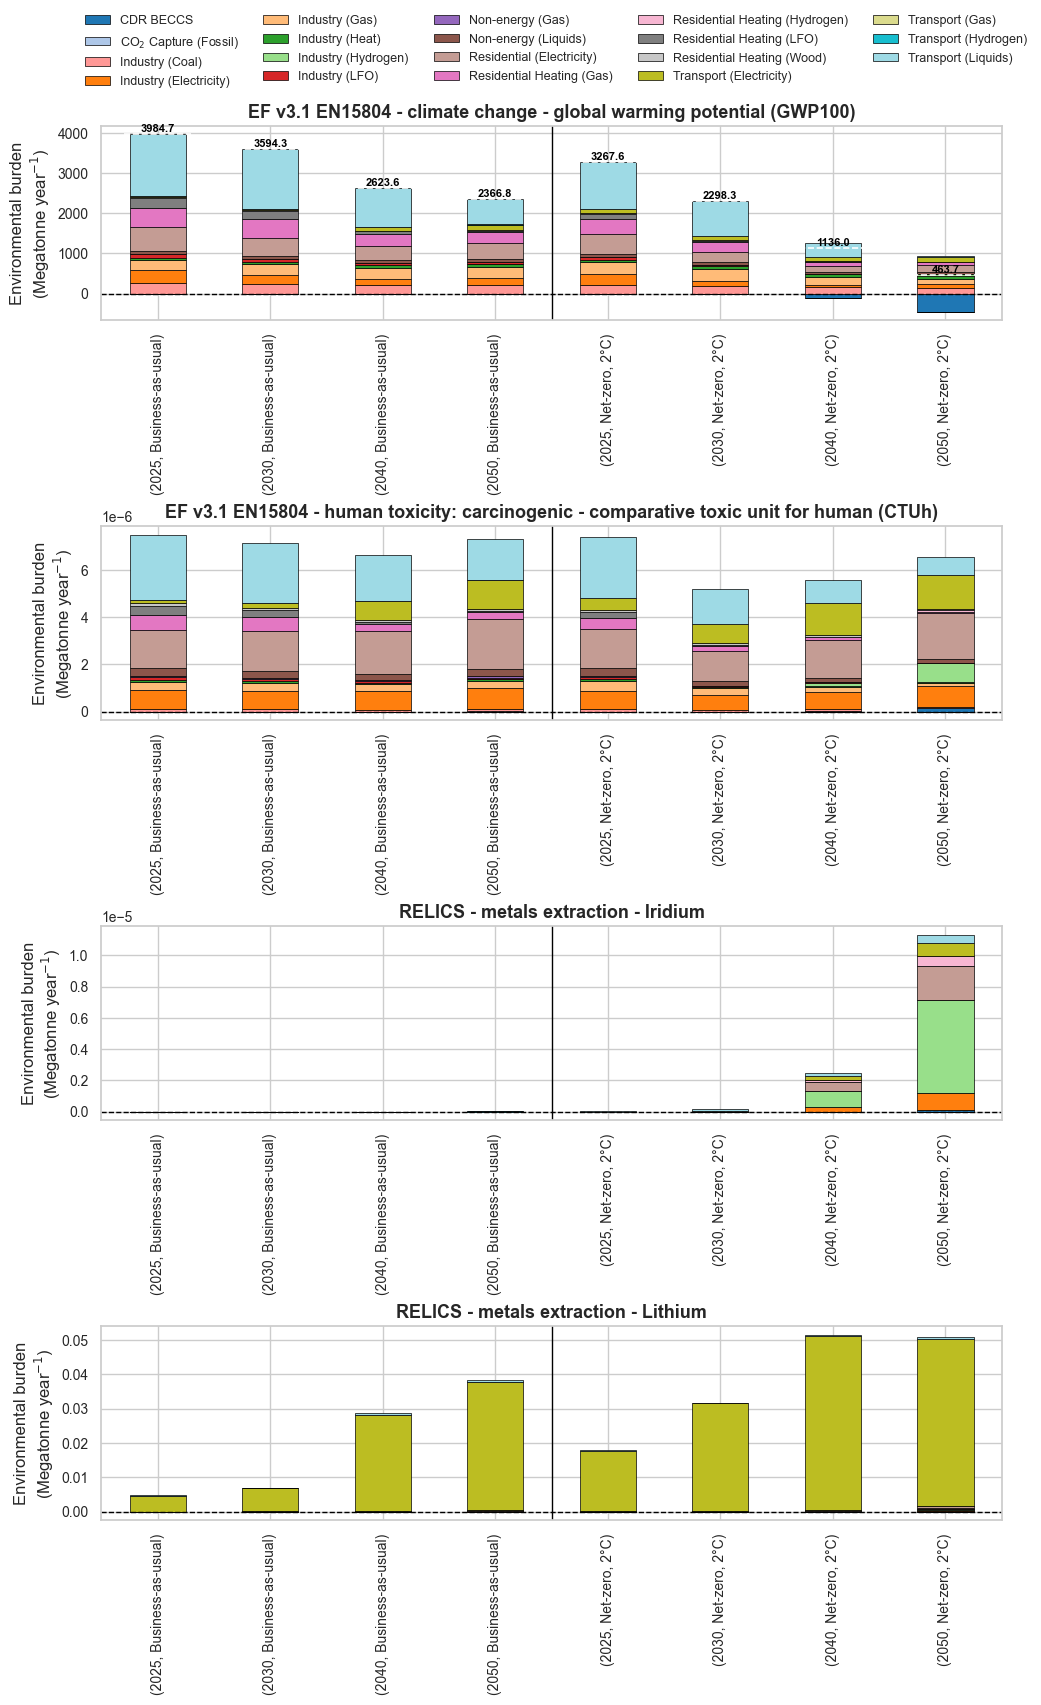

In [13]:
# Ensure the correct column for the amount value (change if needed)
value_col = 'value'

# Set general style and font
sns.set_theme(style="whitegrid")
#mpl.rcParams['font.family'] = 'DejaVu Serif'  # Change if preferred
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 9

nice_names = {
    'SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce': 'Business-as-usual',
    'SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZero_ce - fc_nz': 'Net-zero, 2°C',
    # Add more mappings as needed
}

# Define renaming dictionary for variable names
rename_dict = {
    # Scenario OPEN-PROM Final Energy:
    'FE_cdr_beccs': 'CDR BECCS',
    'FE_co2_capture_fossil': 'CO$_2$ Capture (Fossil)',
    'FE_industry_process_coal': 'Industry (Coal)',
    'FE_industry_process_electricity': 'Industry (Electricity)',
    'FE_industry_process_heat': 'Industry (Heat)',
    'FE_industry_process_hydrogen': 'Industry (Hydrogen)',
    'FE_industry_process_light_fuel_oil': 'Industry (LFO)',
    'FE_industry_process_natural_gas': 'Industry (Gas)',
    'FE_non_energy_gas': 'Non-energy (Gas)',
    'FE_non_energy_liquids': 'Non-energy (Liquids)',
    'FE_residential_electricity': 'Residential (Electricity)',
    'FE_residential_space_heating_gas': 'Residential Heating (Gas)',
    'FE_residential_space_heating_hydrogen': 'Residential Heating (Hydrogen)',
    'FE_residential_space_heating_light_fuel_oil': 'Residential Heating (LFO)',
    'FE_residential_space_heating_wood': 'Residential Heating (Wood)',
    'FE_transportation_electricity': 'Transport (Electricity)',
    'FE_transportation_gas': 'Transport (Gas)',
    'FE_transportation_hydrogen': 'Transport (Hydrogen)',
    'FE_transportation_liquids': 'Transport (Liquids)',
    # Scenarios production volumes EDM-I:
    'steel_primary': 'Primary steel (BF-BOF)',
     'steel_primary_ccs': 'Primary steel (BF-BOF) with CCS',
     'steel_primary_dri_h2': 'Primary steel (H$_2$-DRI)',
     'steel_primary_dri_ng': 'Primary steel (NG-DRI)',
     'steel_primary_mo_electrolysis': 'Primary steel (electrolysis)',
     'steel_secondary': 'Secondary steel (iron scrap in EAF)',
}


# Apply renamed labels to variable_colors
# Get unique variables (renamed)
raw_variables = df['variable'].unique()
renamed_variables = df['variable'].map(rename_dict).fillna(df['variable']).unique()

def get_distinct_color_palette(n_colors):
    # Start with the colorblind palette (10 max)
    base = sns.color_palette("colorblind")

    if n_colors <= len(base):
        return base[:n_colors]
    
    # Use a distinct matplotlib colormap for large numbers
    cmap = plt.cm.get_cmap('tab20', n_colors)  # or 'tab20b', 'tab20c'
    distinct_colors = [cmap(i) for i in range(n_colors)]
    
    return distinct_colors

# Usage
full_palette = get_distinct_color_palette(len(renamed_variables))

# Assign each variable a color
variable_colors = {
    renamed: full_palette[i] for i, renamed in enumerate(renamed_variables)
}

# Rename variable column in df before pivoting
df['variable_renamed'] = df['variable'].map(rename_dict).fillna(df['variable'])

# Get unique impact categories for subplots
impact_categories = df['impact_category'].unique()#[:3]

# Create subplots
fig, axes = plt.subplots(len(impact_categories), 1, figsize=(10, 4 * len(impact_categories)), sharex=False, constrained_layout=True)

if len(impact_categories) == 1:
    axes = [axes]  # Ensure axes is iterable for a single impact category

# Loop over the axes and impact categories to plot each
for ax, impact_category in zip(axes, impact_categories):
    # Filter for the current impact category
    df_filtered = df[df['impact_category'] == impact_category].reset_index().sort_values(by=['year', 'scenario']).set_index(['year', 'scenario'])
    
    # Pivot data using renamed variables
    df_pivot = df_filtered.pivot_table(index=['year', 'scenario'], 
                                       columns='variable_renamed', 
                                       values=value_col, 
                                       aggfunc='sum').fillna(0).divide(1e9)

    df_pivot.sort_index(level=['scenario','year'], inplace=True)

    # Rename the 'scenario' level in the index
    df_pivot.index = df_pivot.index.set_levels(
        df_pivot.index.levels[1].to_series().replace(nice_names), level='scenario'
    )

    # Ensure variables exist in the color dictionary
    valid_variables = [v for v in df_pivot.columns if v in variable_colors]

    # Plot stacked bar chart
    df_pivot[valid_variables].plot(kind='bar', stacked=True, legend=False,
                                   color=[variable_colors[v] for v in valid_variables], 
                                   ax=ax, width=0.5, edgecolor='black', linewidth=0.5)


    # Add total values on top of bars
    for idx, total in enumerate(df_pivot[valid_variables].sum(axis=1)):
        if total > 1:  # Skip if total is less than zero to make them more meaningful
            ax.text(
                x=idx,
                y=total + (0.002 * abs(total)),  # Slight vertical offset
                s=f'{total:.5f}' if total < 1 else f'{total:.1f}',
                ha='center',
                va='bottom',
                fontsize=8,
                fontweight='bold',
                color='black'
            )
            ax.plot([idx - 0.3, idx + 0.3], [total, total], color='white', linewidth=1.2, linestyle='--')

    # Labels and title
    ax.set_ylabel('Environmental burden\n(Megatonne year$^{-1}$)', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.set_title(f'{impact_category}', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')

    for i, sc in enumerate(df_pivot.index.get_level_values('scenario').unique()):
        if i*(len(df_pivot.index.get_level_values('year').unique())-0.5)>0:
            ax.axvline(x=i*(len(df_pivot.index.get_level_values('year').unique())-0.5), color='black', linewidth=1)

    # Determine y-limits considering negative values
    y_min = df_pivot[valid_variables].min().min()
    y_max = df_pivot[valid_variables].sum(axis=1).max()
    
    # Add a margin for visual clarity
    y_margin = 0.05 * max(abs(y_min), abs(y_max))
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Create a single shared legend after all plots are created
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.55, 1.03), loc='center', fontsize=9, ncols=5, frameon=False)
plt.savefig("figs/impacts_entire_system.png",
            dpi=100,
            bbox_inches="tight",
            pad_inches=0.5)
plt.show()

### Now, we could also do this for separate sub-sectors, for example, the entire steel sector from EDM-I:

In [14]:
p_steel = Pathways(
    datapackage=name_zip_file, #better to use ZIP file.
    #debug=False # when `debug` is True, a local pathways.log file is created and allows tracking the workflow
)
p_steel.units['Mt Crude steel'] = {'kilogram': '1e+9'}
p_steel.units['Mt/year'] = {'kilogram': '1e+9'}

Log file: C:\Users\terlouw_t\AppData\Local\pylca\pathways\Logs\pathways.log


In [15]:
p_steel.calculate(
    methods=methods_sel,
    regions=["RER"],
    scenarios= p.scenarios.pathway.values.tolist(),
    variables= [v for v in p_steel.scenarios.coords["variables"].values if v.startswith("steel_")],
    years=p.scenarios.coords["year"].values.tolist(),
    #use_distributions=0,
    #demand_cutoff=0.001,
    multiprocessing=False,
    double_accounting = [["Industry", "Electricity"], ["Industry", "Heat"]],
)

fp = p_steel.export_results()
# interpolate in-between years
df = pd.read_parquet(fp, engine='pyarrow')
df = df[df["value"]!=0.0]
df = df[~df["value"].isnull()]
df=df.reset_index()
df[['year', 'scenario', 'impact_category','value']].groupby(['year', 'impact_category', 'scenario', ]).sum()/1e9

Calculating LCA results for remind...
--- Calculating LCA results for SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce...
------ Calculating LCA results for 2025...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:45


------ Calculating LCA results for 2030...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:46


------ Calculating LCA results for 2040...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42


------ Calculating LCA results for 2050...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:43


--- Calculating LCA results for SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZero_ce - fc_nz...
------ Calculating LCA results for 2025...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:49


------ Calculating LCA results for 2030...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:50


------ Calculating LCA results for 2040...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:44


------ Calculating LCA results for 2050...


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:52


Results exported to results_20250519_103507.gzip


value
year impact_category                                    scenario                                                        
2025 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.629001e+02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  2.180684e+02
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     5.679529e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  4.816799e-05
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     3.928993e-11
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  3.754705e-10
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.082922e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.323591e-05
2030 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.963667e+02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.767218e+01
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     3.942478e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.729658e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     4.498242e-11
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  7.189239e-10
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     2.594583e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  2.414604e-05
2040 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.003451e+02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  6.726033e+01
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.112947e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.877393e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     8.400694e-12
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  2.994469e-08
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     6.986105e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.181300e-04
2050 EF v3.1 EN15804 - climate change - global warmi... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.372297e+02
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.024964e+02
     EF v3.1 EN15804 - human toxicity: carcinogenic ... SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.394466e-05
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  5.917161e-06
     RELICS - metals extraction - Iridium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     9.160565e-12
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.598443e-07
     RELICS - metals extraction - Lithium               SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce     1.028646e-04
                                                        SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZ...  1.906582e-04

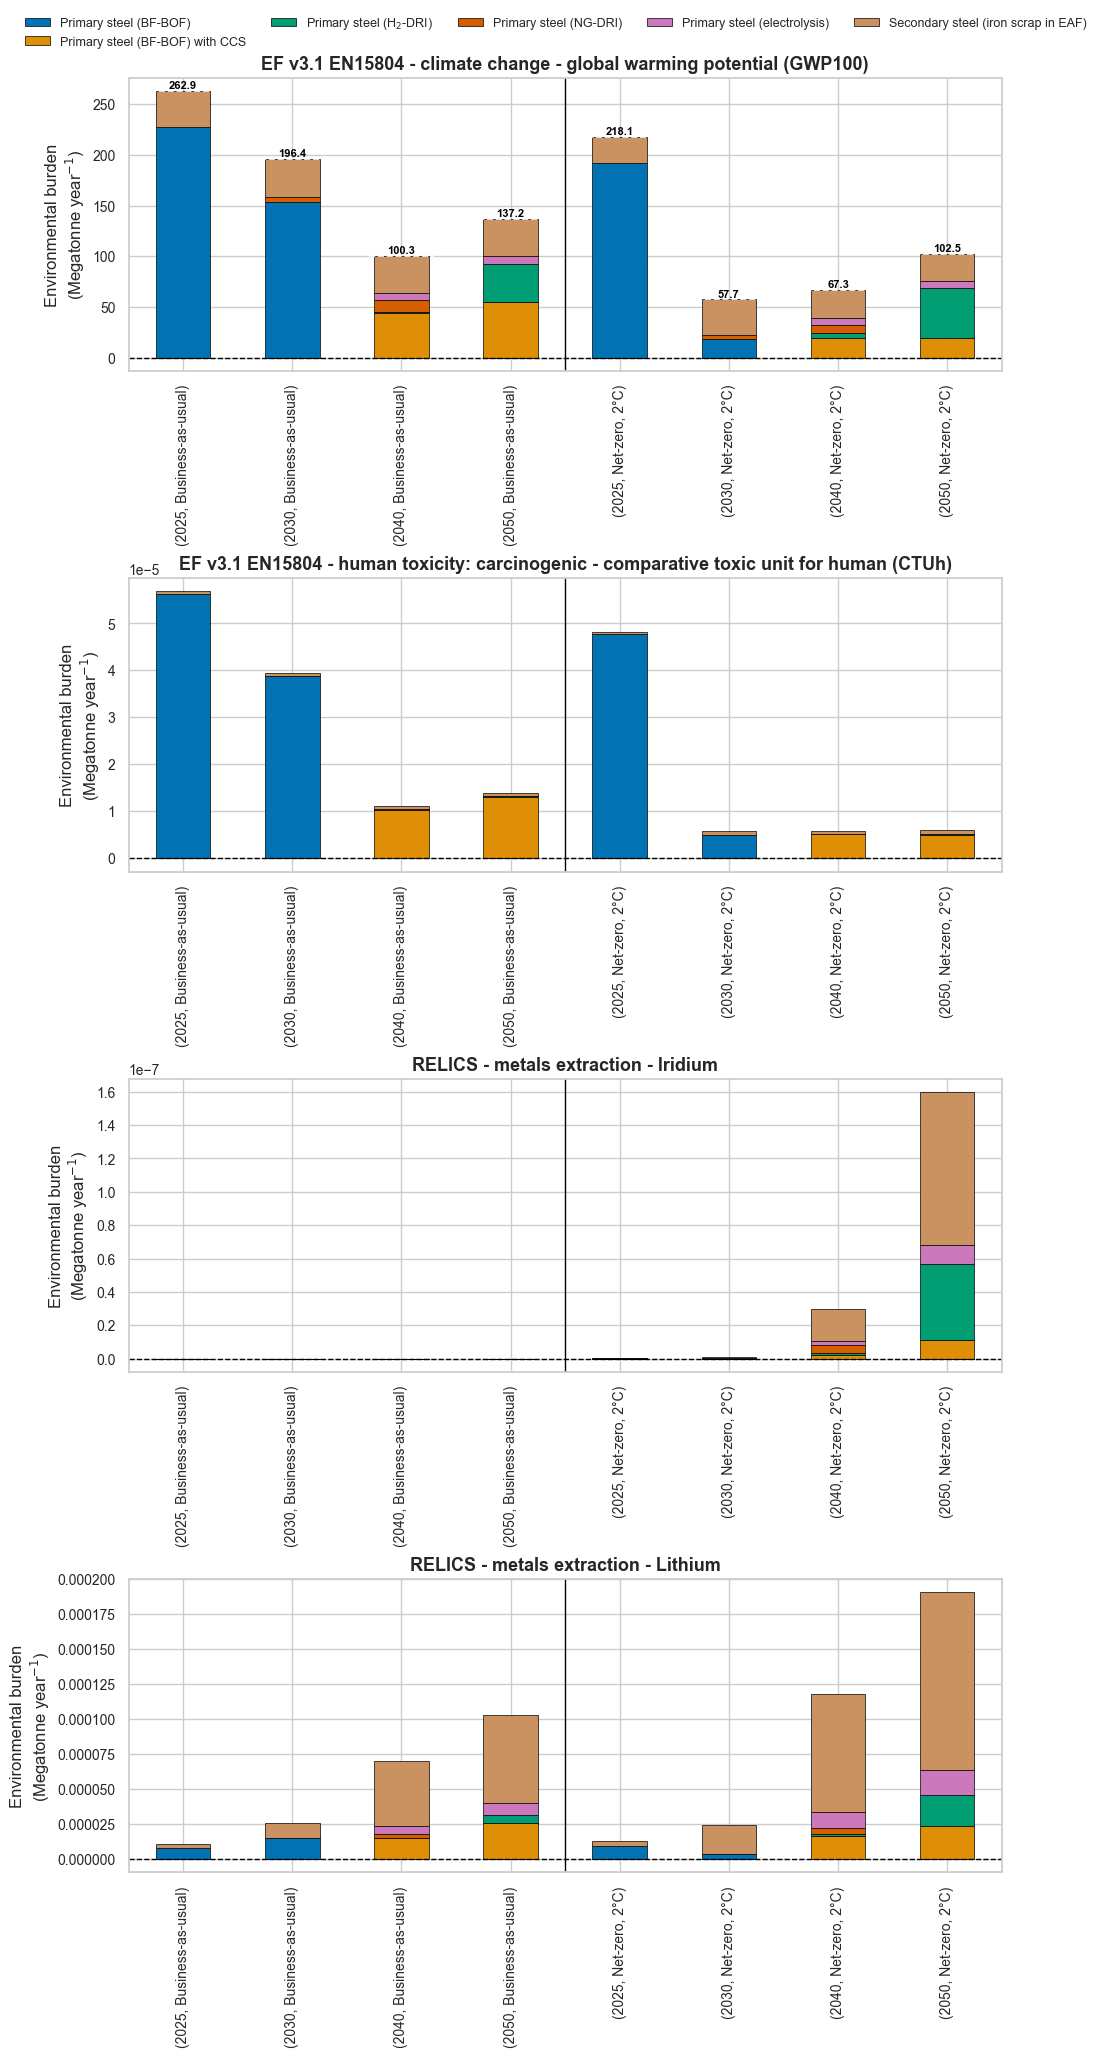

In [16]:
# Ensure the correct column for the amount value (change if needed)
value_col = 'value'

# Set general style and font
sns.set_theme(style="whitegrid")
#mpl.rcParams['font.family'] = 'DejaVu Serif'  # Change if preferred
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 9

nice_names = {
    'SSP2-Base - WP1 NPI - INDEPENDENCE - WP1 NPI_ce': 'Business-as-usual',
    'SSP2-PkBudg1150 - WP1 NetZero - CBAM - WP1 NetZero_ce - fc_nz': 'Net-zero, 2°C',
    # Add more mappings as needed
}

# Define renaming dictionary for variable names
rename_dict = {
    # Scenario OPEN-PROM Final Energy:
    'FE_cdr_beccs': 'CDR BECCS',
    'FE_co2_capture_fossil': 'CO$_2$ Capture (Fossil)',
    'FE_industry_process_coal': 'Industry (Coal)',
    'FE_industry_process_electricity': 'Industry (Electricity)',
    'FE_industry_process_heat': 'Industry (Heat)',
    'FE_industry_process_hydrogen': 'Industry (Hydrogen)',
    'FE_industry_process_light_fuel_oil': 'Industry (LFO)',
    'FE_industry_process_natural_gas': 'Industry (Gas)',
    'FE_non_energy_gas': 'Non-energy (Gas)',
    'FE_non_energy_liquids': 'Non-energy (Liquids)',
    'FE_residential_electricity': 'Residential (Electricity)',
    'FE_residential_space_heating_gas': 'Residential Heating (Gas)',
    'FE_residential_space_heating_hydrogen': 'Residential Heating (Hydrogen)',
    'FE_residential_space_heating_light_fuel_oil': 'Residential Heating (LFO)',
    'FE_residential_space_heating_wood': 'Residential Heating (Wood)',
    'FE_transportation_electricity': 'Transport (Electricity)',
    'FE_transportation_gas': 'Transport (Gas)',
    'FE_transportation_hydrogen': 'Transport (Hydrogen)',
    'FE_transportation_liquids': 'Transport (Liquids)',
    # Scenarios production volumes EDM-I:
    'steel_primary': 'Primary steel (BF-BOF)',
     'steel_primary_ccs': 'Primary steel (BF-BOF) with CCS',
     'steel_primary_dri_h2': 'Primary steel (H$_2$-DRI)',
     'steel_primary_dri_ng': 'Primary steel (NG-DRI)',
     'steel_primary_mo_electrolysis': 'Primary steel (electrolysis)',
     'steel_secondary': 'Secondary steel (iron scrap in EAF)',
}


# Apply renamed labels to variable_colors
# Get unique variables (renamed)
raw_variables = df['variable'].unique()
renamed_variables = df['variable'].map(rename_dict).fillna(df['variable']).unique()

def get_distinct_color_palette(n_colors):
    # Start with the colorblind palette (10 max)
    base = sns.color_palette("colorblind")

    if n_colors <= len(base):
        return base[:n_colors]
    
    # Use a distinct matplotlib colormap for large numbers
    cmap = plt.cm.get_cmap('tab20', n_colors)  # or 'tab20b', 'tab20c'
    distinct_colors = [cmap(i) for i in range(n_colors)]
    
    return distinct_colors

# Usage
full_palette = get_distinct_color_palette(len(renamed_variables))

# Assign each variable a color
variable_colors = {
    renamed: full_palette[i] for i, renamed in enumerate(renamed_variables)
}

# Rename variable column in df before pivoting
df['variable_renamed'] = df['variable'].map(rename_dict).fillna(df['variable'])

# Get unique impact categories for subplots
impact_categories = df['impact_category'].unique()#[:3]

# Create subplots
fig, axes = plt.subplots(len(impact_categories), 1, figsize=(10, 5 * len(impact_categories)), sharex=False, constrained_layout=True)

if len(impact_categories) == 1:
    axes = [axes]  # Ensure axes is iterable for a single impact category

# Loop over the axes and impact categories to plot each
for ax, impact_category in zip(axes, impact_categories):
    # Filter for the current impact category
    df_filtered = df[df['impact_category'] == impact_category].reset_index().sort_values(by=['year', 'scenario']).set_index(['year', 'scenario'])
    
    # Pivot data using renamed variables
    df_pivot = df_filtered.pivot_table(index=['year', 'scenario'], 
                                       columns='variable_renamed', 
                                       values=value_col, 
                                       aggfunc='sum').fillna(0).divide(1e9)

    df_pivot.sort_index(level=['scenario','year'], inplace=True)

    # Rename the 'scenario' level in the index
    df_pivot.index = df_pivot.index.set_levels(
        df_pivot.index.levels[1].to_series().replace(nice_names), level='scenario'
    )

    # Ensure variables exist in the color dictionary
    valid_variables = [v for v in df_pivot.columns if v in variable_colors]

    # Plot stacked bar chart
    df_pivot[valid_variables].plot(kind='bar', stacked=True, legend=False,
                                   color=[variable_colors[v] for v in valid_variables], 
                                   ax=ax, width=0.5, edgecolor='black', linewidth=0.5)


    # Add total values on top of bars
    for idx, total in enumerate(df_pivot[valid_variables].sum(axis=1)):
        if total >1:  # Skip if total is zero
            ax.text(
                x=idx,
                y=total + (0.002 * abs(total)),  # Slight vertical offset
                s=f'{total:.5f}' if total < 1 else f'{total:.1f}',
                ha='center',
                va='bottom',
                fontsize=8,
                fontweight='bold',
                color='black'
            )
            ax.plot([idx - 0.3, idx + 0.3], [total, total], color='white', linewidth=1.2, linestyle='--')

    # Labels and title
    ax.set_ylabel('Environmental burden\n(Megatonne year$^{-1}$)', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.set_title(f'{impact_category}', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')

    for i, sc in enumerate(df_pivot.index.get_level_values('scenario').unique()):
        if i*(len(df_pivot.index.get_level_values('year').unique())-0.5)>0:
            ax.axvline(x=i*(len(df_pivot.index.get_level_values('year').unique())-0.5), color='black', linewidth=1)

    # Determine y-limits considering negative values
    y_min = df_pivot[valid_variables].min().min()
    y_max = df_pivot[valid_variables].sum(axis=1).max()
    
    # Add a margin for visual clarity
    y_margin = 0.05 * max(abs(y_min), abs(y_max))
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Create a single shared legend after all plots are created
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.55, 1.01), loc='center', fontsize=9, ncols=5, frameon=False)
plt.savefig("figs/impacts_steel_system.png",
            dpi=100,
            bbox_inches="tight",
            pad_inches=0.5)
plt.show()